<a href="https://colab.research.google.com/github/JNPauli/Emotional_Machines/blob/main/Classification_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. This notebook is the continuation to the preprocessing.ipynb notebook.

1. Import all neccessary modules

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Import X and y

In [ ]:
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [ ]:
os.chdir('/content/drive/MyDrive/Thesis')

In [ ]:
y = np.load('train_con.npy')

In [ ]:
y_ = y[0:10000]
y_frames = y[14276:]

In [ ]:
y_all = np.concatenate((y_,y_frames))

NEW APPROACH:

Fit CNN on X

1. Read `n-rows`from X.

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [ ]:
X = np.load('X_npy.npy')

In [ ]:
X_train_,X_test_,y_train_,y_test_ = train_test_split(X,y_,test_size=0.2,random_state=42)

In [ ]:
del X,y_
gc.collect()

11

In [ ]:
X_frames = np.load('frames_npy.npy')

In [ ]:
X_train_f,X_test_f,y_train_f,y_test_f = train_test_split(X_frames,y_frames,test_size=0.2,random_state=42)

In [ ]:
del X_frames,y_frames
gc.collect()

11

Converting X to appropriate Datatype...

In [ ]:
X_tensor_train = torch.from_numpy(X_train_)
del X_train_
gc.collect()
X_tensor_test = torch.from_numpy(X_test_)
del X_test_
gc.collect()

y_tensor_train = torch.from_numpy(y_train_)
del y_train_
gc.collect()
y_tensor_test = torch.from_numpy(y_test_)
del y_test_
gc.collect()


0

In [ ]:
X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)
X_tensor_test = torch.tensor(X_tensor_test,dtype = torch.float32)


y_tensor_train = y_tensor_train.type(torch.LongTensor)
y_tensor_test = y_tensor_test.type(torch.LongTensor)


<ipython-input-16-224f70498d00>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)
<ipython-input-16-224f70498d00>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_test = torch.tensor(X_tensor_test,dtype = torch.float32)


In [ ]:
X_tensor_train_ = torch.from_numpy(X_train_f)
del X_train_f
gc.collect()
X_tensor_test_ = torch.from_numpy(X_test_f)
del X_test_f
gc.collect()



y_tensor_train_ = torch.from_numpy(y_train_f)
del y_train_f
gc.collect()
y_tensor_test_ = torch.from_numpy(y_test_f)
del y_test_f
gc.collect()


0

In [ ]:
X_tensor_train_ = torch.tensor(X_tensor_train_,dtype = torch.float32)
X_tensor_test_ = torch.tensor(X_tensor_test_,dtype = torch.float32)


y_tensor_train_ = y_tensor_train_.type(torch.LongTensor)
y_tensor_test_ = y_tensor_test_.type(torch.LongTensor)


<ipython-input-18-c8804b6c7935>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_train_ = torch.tensor(X_tensor_train_,dtype = torch.float32)
<ipython-input-18-c8804b6c7935>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor_test_ = torch.tensor(X_tensor_test_,dtype = torch.float32)


In [ ]:
X_tensor_train = torch.cat((X_tensor_train,X_tensor_train_),0)
X_tensor_test = torch.cat((X_tensor_test,X_tensor_test_),0)


y_tensor_train = torch.cat((y_tensor_train,y_tensor_train_),0)
y_tensor_test = torch.cat((y_tensor_test,y_tensor_test_),0)


In [ ]:
X_tensor_train = X_tensor_train.expand(-1, 3, -1, -1)
X_tensor_test = X_tensor_test.expand(-1, 3, -1, -1)


In [ ]:
print('training shape X is {}, , test shape X is{}'.format(X_tensor_train.shape,X_tensor_test.shape))

training shape X is torch.Size([13878, 3, 224, 224]), , test shape X istorch.Size([3470, 3, 224, 224])


To get max value of classN-1

In [ ]:
y_tensor_train = y_tensor_train-1
y_tensor_test = y_tensor_test-1


Setup custom dataset class

In [ ]:
train_mean = (0.0505, 0.0505, 0.0505)
train_std = (0.0516, 0.0516, 0.0516)

In [ ]:
test_mean = ([0.0510, 0.0510, 0.0510])
test_std = ([0.0520, 0.0520, 0.0520])

In [ ]:
val_mean = ([0.0512, 0.0512, 0.0512])
val_std = ([0.0518, 0.0518, 0.0518])

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, X, y,transform=None):
        self.X = X
        self.y = y
        self.transform = transforms.Normalize((0.0505, 0.0505, 0.0505), (0.0516, 0.0516, 0.0516))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
          X = self.transform(X)

        return X, y

In [ ]:
class TestDataset(Dataset):
    def __init__(self, X, y,transform=None):
        self.X = X
        self.y = y
        self.transform = transforms.Normalize(train_mean, train_std)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
          X = self.transform(X)

        return X, y

In [ ]:
class ValDataset(Dataset):
    def __init__(self, X, y,transform=None):
        self.X = X
        self.y = y
        self.transform = transforms.Normalize(train_mean, train_std)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
          X = self.transform(X)

        return X, y

In [ ]:
dataset_train = TrainDataset(X_tensor_train,y_tensor_train,transform=True)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_test = TestDataset(X_tensor_test,y_tensor_test,transform=True)
dataloader_test = DataLoader(dataset_test, batch_size = 32)#,shuffle=True)


Setting up the CNN.

In [ ]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.batch = nn.BatchNorm2d(32)
        #self.conv2 = nn.Conv2d(32,64,3) #remove layer
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(394272, 128)
        #self.fc2 = nn.Linear(128,10)
        self.Arousal = nn.Linear(128,10) #3
        self.Valence = nn.Linear(128,10)
        self.Dominance = nn.Linear(128,10)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch(x)
        x = F.relu(x)
        #x = self.conv2(x)
        #x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        #x = self.fc2(x)
        Arousal = self.Arousal(x)
        Valence = self.Valence(x)
        Dominance = self.Dominance(x)
        return Arousal, Valence, Dominance
#removed

In [ ]:
SalienceNet = CNN()
#SalienceNet.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
pip install torcheval

In [ ]:
from torcheval.metrics.functional import multiclass_f1_score

In [ ]:
F1 = multiclass_f1_score

In [83]:
from tqdm import tqdm
def train(net, loss_fn, dataloader_train,
          epoch=10, learning_rate=0.0001):
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=1e-4)#torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=1e-4) # weight decay as a regularization technique to defy overfitting
    for param in model_CNN.parameters():
        param.requires_grad = False
    for param in model_CNN.Arousal.parameters():
      param.requires_grad = True
    for param in model_CNN.Valence.parameters():
      param.requires_grad = True
    for param in model_CNN.Dominance.parameters():
      param.requires_grad = True
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    f1_accuracy_train=[]
    f1_accuracy_val=[]

    train_epoch_loss = []
    val_epoch_loss = []

    net.to(device)
    net.train()
    for i in range(epoch):
        train_loop = tqdm(dataloader_train)

        total = 0
        correct_a,correct_v,correct_d=0,0,0
        correct_a_f1,correct_v_f1,correct_d_f1=0,0,0
        val_a_f1,val_v_f1,val_d_f1=0,0,0


        for data, label in train_loop:
            data, label = data.to(device), label.to(device)
            #make prediction
            Arousal,Valence,Dominance = net(data.float())

            _a, y_pred_train_arousal = torch.max(Arousal,1)
            _v, y_pred_train_valence = torch.max(Valence,1)
            _d, y_pred_train_dominance = torch.max(Dominance,1)

            total += label[:,0].size(0)+label[:,1].size(0)+label[:,2].size(0)

            correct_a += (y_pred_train_arousal == label[:,0]).sum().item()
            correct_v += (y_pred_train_valence == label[:,1]).sum().item()
            correct_d += (y_pred_train_dominance == label[:,2]).sum().item()

            correct_a_f1 += F1(y_pred_train_arousal, label[:,0],average='weighted',num_classes=10)
            correct_v_f1 += F1(y_pred_train_valence, label[:,1],average='weighted',num_classes=10)
            correct_d_f1 += F1(y_pred_train_dominance, label[:,2],average='weighted',num_classes=10)

            sum_f1 = ((correct_a_f1/len(dataloader_train))+(correct_d_f1/len(dataloader_train))+(correct_v_f1/len(dataloader_train)))

            sum_correct = (correct_a+correct_v+correct_d)
            # Zero out the gradients
            optimizer.zero_grad()

            # Calculate loss.
            #loss = loss_fn(output,label)#torch.max(label.long(), 1)[0])
            loss_arousal = loss_fn(Arousal,label[:,0])
            loss_valence = loss_fn(Valence,label[:,1])
            loss_dominance = loss_fn(Dominance,label[:,2])
            loss=loss_arousal+loss_valence+loss_dominance


            # Backpropagation and gradient update.
            loss.backward()# Calculate gradients. #retrain_graph=True

            optimizer.step() # Apply gradient update

            train_loss.append(loss.item())
            train_loop.set_description(f"Epoch [{i+1}/{epoch}]")

        train_accuracy.append(sum_correct/total)
        f1_accuracy_train.append(sum_f1)
        train_epoch_loss.append((np.array(train_loss).mean()))

    torch.save(net,"/content/drive/MyDrive/Thesis/model.pt")
    print('finished training')






    return train_loss,train_epoch_loss,train_accuracy, f1_accuracy_train


In [87]:
def test(net,loss_fn,dataloader_test):
  net.eval()
  test_loss = []
  test_total = 0
  test_arousal,test_valence, test_dominance = 0,0,0

  test_acc = []
  test_loop = tqdm(dataloader_test)
  i=0
  for batch, (data, labels) in enumerate(test_loop):
      print('testing...')

      data, labels = data.to(device), labels.to(device)
      arousal,valence,dominance = net(data.float())

      __a, y_pred_test_arousal = torch.max(arousal,1)
      __v, y_pred_test_valence = torch.max(valence,1)
      __d, y_pred_test_dominance = torch.max(dominance,1)

      arousal_t = loss_fn(arousal,labels[:,0])
      valence_t = loss_fn(valence,labels[:,1])
      dominance_t = loss_fn(dominance,labels[:,2])

      test_l = arousal_t+valence_t+dominance_t

      test_loss.append(test_l.item())
      test_loop.set_description(f"Batch [{i+1}/{batch}]")
      i=+1

      test_total += labels[:,0].size(0)+labels[:,1].size(0)+labels[:,2].size(0)

      test_arousal += F1(y_pred_test_arousal,labels[:,0],num_classes=10,average='weighted')
      test_valence += F1(y_pred_test_valence,labels[:,1],num_classes=10,average='weighted')
      test_dominance += F1(y_pred_test_dominance,labels[:,2],num_classes=10,average='weighted')

      sum_correct_test = ((test_arousal/len(dataloader_test))+(test_valence/len(dataloader_test))+(test_dominance/len(dataloader_test)))
      #test_correct += (y_pred_test==torch.max(labels,1)[0]).sum().item()

      test_acc.append(sum_correct_test)
    #y_pred_test = torch.softmax(outputs,dim=1).argmax(dim=1)

   # print('test acc is {}'.format(test_acc)
  return test_loss, test_acc

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from IPython.display import Javascript

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

<IPython.core.display.Javascript object>

In [ ]:
from torchvision import models

In [ ]:
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
class CNN1(nn.Module):
    def __init__(self, pretrained):
        super(CNN1, self).__init__()
        if pretrained is True:
            self.model = models.__dict__["alexnet"](pretrained="imagenet")
        else:
            self.model = models.__dict__["alexnet"](pretrained=None)
        self.Arousal= nn.Linear(256, 10)
        self.Valence = nn.Linear(256,10)
        self.Dominance = nn.Linear(256, 10)

    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        Arousal = self.Arousal(x)
        Valence = self.Valence(x)
        Dominance = self.Dominance(x)
        return Arousal, Valence, Dominance
        return {'label1': label1, 'label2': label2, 'label3': label3}

In [ ]:
model_CNN = CNN1(True).to(device)

In [ ]:
for param in model_CNN.parameters():
        param.requires_grad = False
for param in model_CNN.Arousal.parameters():
  param.requires_grad = True
for param in model_CNN.Valence.parameters():
  param.requires_grad = True
for param in model_CNN.Dominance.parameters():
  param.requires_grad = True

In [84]:
np.random.seed(1)
torch.manual_seed(1)

train_loss,train_epoch_loss,train_acc,f1_acc=train(net=model_CNN,loss_fn=criterion,dataloader_train=dataloader_train,
                 epoch=25,learning_rate=0.0005)




Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Epoch [25/25]: 100%|██████████| 434/434 [00:19<00:00, 22.77it/s]


finished training


ValueError: ignored

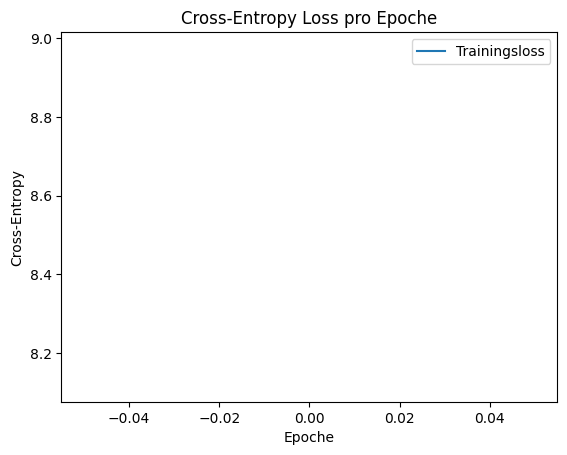

In [85]:
plt.plot(train_epoch_loss, label = 'Trainingsloss')
plt.xlabel('Epoche')
plt.ylabel('Cross-Entropy')
plt.title('Cross-Entropy Loss pro Epoche')
plt.legend()
plt.show()

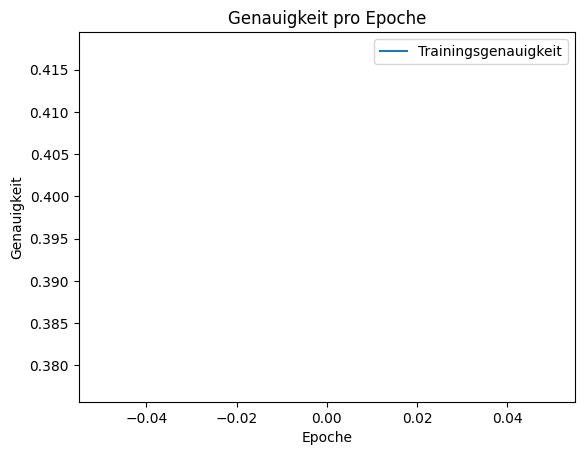

In [86]:
plt.plot(torch.tensor(f1_acc,device='cpu'), label = 'Trainingsgenauigkeit')
plt.xlabel('Epoche')
plt.ylabel('Genauigkeit')
plt.title('Genauigkeit pro Epoche')
plt.legend()
plt.show()

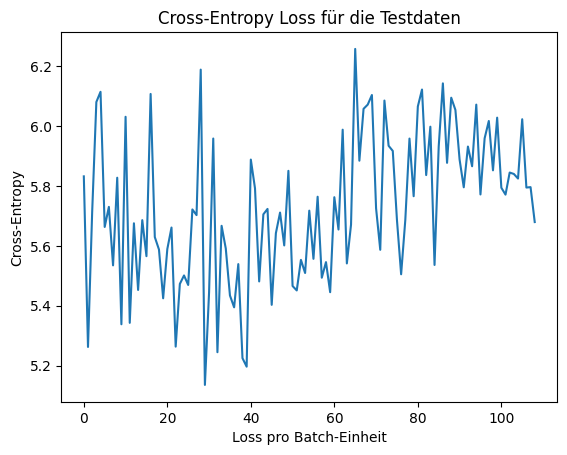

In [66]:
plt.plot(test_loss)
plt.xlabel('Loss pro Batch-Einheit')
plt.ylabel('Cross-Entropy')
plt.title('Cross-Entropy Loss für die Testdaten')
plt.show()

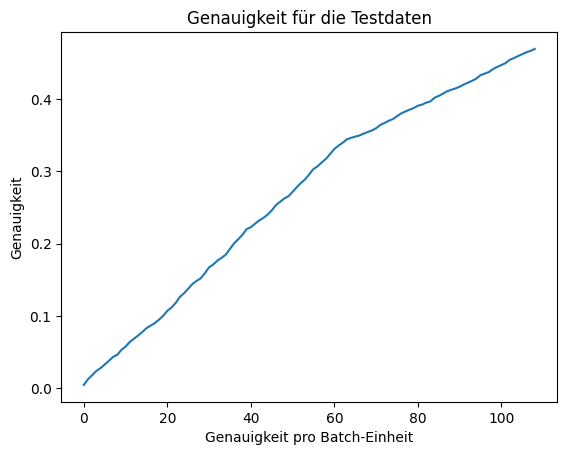

In [67]:
plt.plot(torch.tensor(test_acc,device='cpu'))
plt.xlabel('Genauigkeit pro Batch-Einheit')
plt.ylabel('Genauigkeit')
plt.title('Genauigkeit für die Testdaten')
plt.show()

In [88]:
model_pretrained = torch.load("/content/drive/MyDrive/Thesis/model.pt")

model.eval()

CNN1(
  (model): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): L

In [89]:
loss,acc= test(net=model_pretrained,dataloader_test=dataloader_test,loss_fn=criterion)

Batch [2/4]:   3%|▎         | 3/109 [00:00<00:04, 21.39it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/9]:   8%|▊         | 9/109 [00:00<00:04, 22.39it/s]WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.


testing...
testing...
testing...
testing...
testing...


Batch [2/14]:  14%|█▍        | 15/109 [00:00<00:03, 23.56it/s]

testing...
testing...
testing...
testing...
testing...
testing...


Batch [2/20]:  19%|█▉        | 21/109 [00:00<00:03, 23.51it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/25]:  22%|██▏       | 24/109 [00:01<00:03, 23.78it/s]WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.


testing...
testing...
testing...
testing...
testing...


Batch [2/30]:  28%|██▊       | 30/109 [00:01<00:03, 23.35it/s]WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.


testing...
testing...
testing...
testing...
testing...


Batch [2/35]:  30%|███       | 33/109 [00:01<00:03, 23.22it/s]WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.


testing...
testing...
testing...
testing...
testing...


Batch [2/40]:  36%|███▌      | 39/109 [00:01<00:02, 23.53it/s]WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.


testing...
testing...
testing...
testing...
testing...


Batch [2/45]:  41%|████▏     | 45/109 [00:01<00:02, 23.52it/s]WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.


testing...
testing...
testing...
testing...
testing...


Batch [2/50]:  47%|████▋     | 51/109 [00:02<00:02, 24.04it/s]

testing...
testing...
testing...
testing...
testing...
testing...


Batch [2/56]:  52%|█████▏    | 57/109 [00:02<00:02, 23.55it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/61]:  55%|█████▌    | 60/109 [00:02<00:02, 23.23it/s]WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.


testing...
testing...
testing...
testing...
testing...


Batch [2/66]:  61%|██████    | 66/109 [00:02<00:01, 23.41it/s]WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.


testing...
testing...
testing...
testing...
testing...


Batch [2/71]:  66%|██████▌   | 72/109 [00:03<00:01, 23.99it/s]

testing...
testing...
testing...
testing...
testing...
testing...


Batch [2/77]:  72%|███████▏  | 78/109 [00:03<00:01, 24.24it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/82]:  74%|███████▍  | 81/109 [00:03<00:01, 24.01it/s]WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.


testing...
testing...
testing...
testing...
testing...
testing...


Batch [2/88]:  80%|███████▉  | 87/109 [00:03<00:00, 24.07it/s]WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.


testing...
testing...
testing...
testing...
testing...


Batch [2/93]:  85%|████████▌ | 93/109 [00:03<00:00, 23.50it/s]WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.


testing...
testing...
testing...
testing...
testing...


Batch [2/98]:  91%|█████████ | 99/109 [00:04<00:00, 23.21it/s]

testing...
testing...
testing...
testing...
testing...


Batch [2/103]:  94%|█████████▎| 102/109 [00:04<00:00, 23.29it/s]WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.


testing...
testing...
testing...
testing...
testing...


Batch [2/108]: 100%|██████████| 109/109 [00:04<00:00, 23.49it/s]

testing...
testing...
testing...
testing...
testing...


In [91]:
loss

[tensor(0.0044, device='cuda:0'),
 tensor(0.0123, device='cuda:0'),
 tensor(0.0178, device='cuda:0'),
 tensor(0.0235, device='cuda:0'),
 tensor(0.0284, device='cuda:0'),
 tensor(0.0341, device='cuda:0'),
 tensor(0.0400, device='cuda:0'),
 tensor(0.0460, device='cuda:0'),
 tensor(0.0494, device='cuda:0'),
 tensor(0.0556, device='cuda:0'),
 tensor(0.0607, device='cuda:0'),
 tensor(0.0656, device='cuda:0'),
 tensor(0.0722, device='cuda:0'),
 tensor(0.0775, device='cuda:0'),
 tensor(0.0833, device='cuda:0'),
 tensor(0.0889, device='cuda:0'),
 tensor(0.0927, device='cuda:0'),
 tensor(0.0970, device='cuda:0'),
 tensor(0.1014, device='cuda:0'),
 tensor(0.1072, device='cuda:0'),
 tensor(0.1132, device='cuda:0'),
 tensor(0.1176, device='cuda:0'),
 tensor(0.1236, device='cuda:0'),
 tensor(0.1321, device='cuda:0'),
 tensor(0.1374, device='cuda:0'),
 tensor(0.1437, device='cuda:0'),
 tensor(0.1501, device='cuda:0'),
 tensor(0.1550, device='cuda:0'),
 tensor(0.1588, device='cuda:0'),
 tensor(0.1651

In [ ]:
n